# **ARIMA Model**

## Introduction to the topic

In this section, we are trying to predict the future sales trend of a particular item in a particular store using the ARIMA model.

An ARIMA (Auto-Regressive Integrated Moving Average) is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends.

*  Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
* Integrated (I): represents the differencing of raw observations to allow the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
* Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each component in ARIMA functions as a parameter with a standard notation. For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used. The parameters can be defined as:

* p: the number of lag observations in the model, also known as the lag order.
* d: the number of times the raw observations are differenced; also known as the degree of differencing.
* q: the size of the moving average window, also known as the order of the moving average.

Source: https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp

## Describing the Dataset

The dataset which I have used is a Sales dataset for number of items sold in a particular store over 5+ years. I had the data for 10 different stores and 10+ items in each store but for the purpsoes of demonstration, we have taken only 1 store and 1 item. I do not know what the store is or what the items are as the data is picked up from Kaggle and the description does not mention anything. As the goal is to do a time series forecasting using ARIMA, the data seemed very structured and great to work with hence the choice.

After filtering the data accordingly, the data we have gives us information about the sales of 1 item sold in 1 store from 1 January 2013 to 31 December 2017.

Source of Dataset: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

## Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

## Importing Data, Processing it and Visualizing it

In [2]:
df = pd.read_csv('/content/train.csv')            #Reading Data
df = df[df['store']==1]                           #Filtering Store number 1
df = df[df['item']==1]                            #Filtering Item number 1
df = df.drop(['item','store'], axis=1)            #Dropping all other columns
df['date'] = pd.to_datetime(df['date'])           #Converting to proper format
df

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
...,...,...
1821,2017-12-27,14
1822,2017-12-28,19
1823,2017-12-29,15
1824,2017-12-30,27


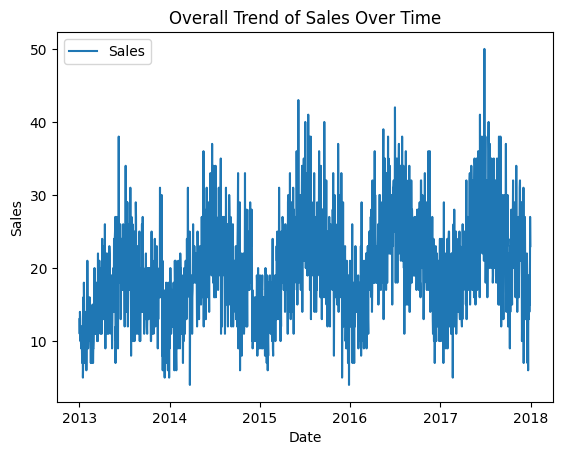

In [3]:
# Visualising the Overall Trend of Sales with respect to Date
sns.lineplot(x="date", y="sales", data=df)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Overall Trend of Sales Over Time")
plt.legend(["Sales"])
plt.show()

## Checking if the Data is Stationary

Stationarity is a fundamental assumption of ARIMA (AutoRegressive Integrated Moving Average) models because it simplifies the underlying process being modeled and facilitates accurate parameter estimation and forecasting. A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time. Here's why stationarity is needed for ARIMA:

1. Constant Statistical Properties: Stationarity implies that the statistical
properties of the time series, such as mean, variance, and autocovariance, remain constant over time. This allows us to make predictions based on past observations because the underlying data-generating process is assumed to be stable.
2. Model Stability: In a non-stationary time series, the statistical properties of the data change over time, making it challenging to develop a stable model. A non-stationary series might exhibit trends, seasonal patterns, or other forms of structural changes that can lead to biased parameter estimates and unreliable forecasts.
3. Autocorrelation Structure: ARIMA models are built on the assumption of autocorrelation, meaning that the value of the series at any given time is correlated with its previous values. Stationarity ensures that this autocorrelation structure is consistent across time, allowing ARIMA models to effectively capture and model the underlying dependencies in the data.

In summary, stationarity is essential for ARIMA models because it ensures stable statistical properties, facilitates accurate parameter estimation, and enables reliable forecasting by capturing the underlying autocorrelation structure of the time series data.

For this very reason, we try to do perform manipulations to make the data stationary. This is explaioned in the section below.

Source: https://otexts.com/fpp2/stationarity.html

In [4]:
#Writing a Function to check for Stationarity by giving a condition on p-value
def check_stationarity(input_data):

    # Assume 'data' is your time series data
    result = adfuller(input_data)

    # Extracting test statistics and p-value
    adf_statistic = result[0]
    p_value = result[1]

    # Printing test statistics and p-value
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)

    # Checking for stationarity based on p-value (we can define it acccording to our choice)
    if p_value < 0.02:
        print("Reject the null hypothesis. The data is stationary.")
    else:
        print("Fail to reject the null hypothesis. The data is non-stationary.")

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a unit root is present in a time series dataset. A unit root indicates that a time series is non-stationary, meaning its statistical properties (such as mean and variance) change over time. The ADF test helps assess whether differencing is necessary to make a time series stationary.

The ADF test provides several statistics, including the ADF statistic and the p-value. Here's what they tell you about stationarity:

1. ADF Statistic: The ADF statistic is a negative number. The more negative it is, the stronger the evidence against the presence of a unit root (i.e., in favor of stationarity). A more negative ADF statistic indicates a greater likelihood that the series is stationary.
2. P-value: The p-value associated with the ADF statistic indicates the probability of observing the ADF statistic if the null hypothesis of a unit root is true (i.e., if the series is non-stationary). A smaller p-value suggests stronger evidence against the presence of a unit root and in favor of stationarity. Conventionally, if the p-value is less than a chosen significance level (e.g., 0.05), the null hypothesis of a unit root is rejected, and the series is considered stationary.

In summary:

A smaller ADF statistic and a smaller p-value indicate stronger evidence against the presence of a unit root and in favor of stationarity.
If the ADF statistic is more negative and/or the p-value is smaller than the chosen significance level (e.g., 0.05), you can reject the null hypothesis of a unit root and conclude that the series is likely stationary.
Conversely, if the p-value is larger than the chosen significance level, you fail to reject the null hypothesis, indicating that the series may be non-stationary.

In [5]:
#checking stationarity of our time series
check_stationarity(df['sales'])

ADF Statistic: -3.1576705563328042
p-value: 0.02256938062657153
Fail to reject the null hypothesis. The data is non-stationary.


The next step is to plot Autocorrelation and Partial Autocorrelation plots to verify how non-stationary a series is. This is a standard practise.
1. Autocorrelation Plot (ACF): An autocorrelation plot, often referred to as an ACF plot, shows the correlation between a series and its lagged values. The x-axis represents the lag, i.e., the number of time units by which the series is shifted and the y-axis represents the correlation coefficient between the series and its lagged values at different lags. Significant autocorrelation at certain lags indicates a repeating pattern in the data that could be captured by autoregressive terms in an ARIMA model.
2. Partial Autocorrelation Plot (PACF): A partial autocorrelation plot, or PACF plot, shows the correlation between a series and its lagged values after removing the effect of intermediate lagged values. The x-axis represents the lag, similar to the ACF plot. The y-axis represents the partial correlation coefficient between the series and its lagged values at different lags, controlling for intermediate lags. Significant partial autocorrelation at certain lags indicates direct relationships between observations at those lags, which can help determine the order of autoregressive terms in an ARIMA model.

In the ACF plot, significant autocorrelation at lag k suggests a potential autoregressive term of order k. In the PACF plot, significant partial autocorrelation at lag k suggests a potential autoregressive term of order k. By analyzing both plots together, analysts can determine suitable values for p and q, which are crucial for building an effective ARIMA model.

We have defined statioanrity to be the case where the p-value is less than 0.02. the p-value associated with our data is 0.022 which is just above the critical value. So in our case we can say that it is borderline stationary (almost stationary). But we can try to make it stationary.

We will make us eof inbuilt functions to do this.

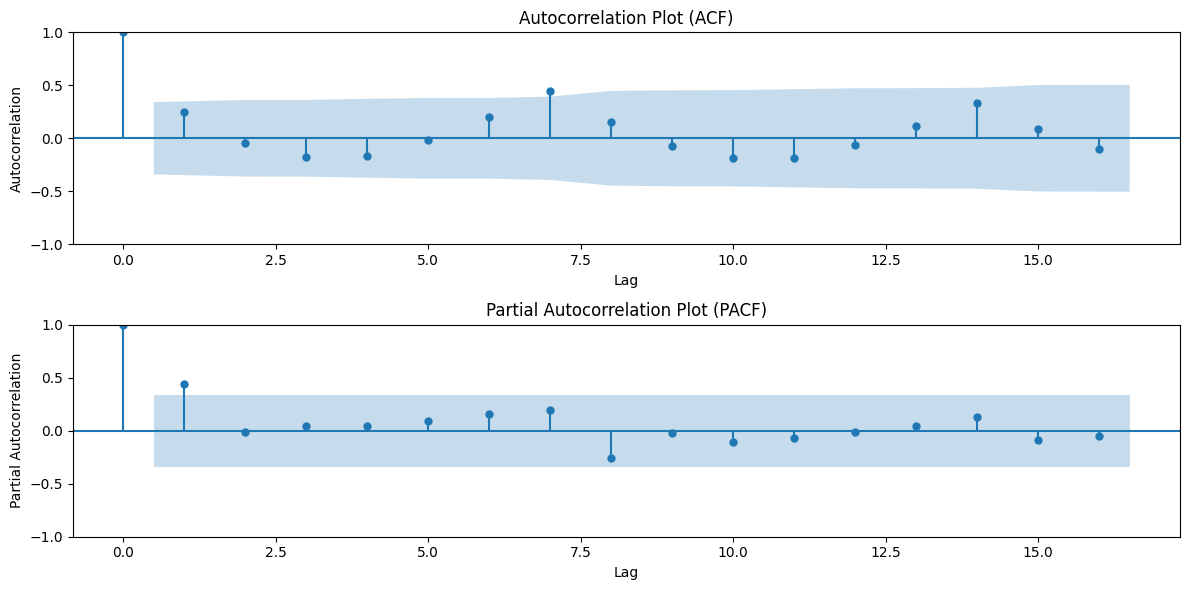

In [6]:
# Calculating autocorrelation and partial autocorrelation
df_acf = acf(df['sales'])           # Auto correlation plot
df_pacf = pacf(df['sales'])         # Partial auto correlation plot

# Creating subplots for ACF and PACF plots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plotting ACF
plot_acf(df_acf, ax=ax1)
ax1.set_title('Autocorrelation Plot (ACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')

# Plotting PACF
plot_pacf(df_pacf, ax=ax2)
ax2.set_title('Partial Autocorrelation Plot (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

From the above plots, we observe that for a lag greater than 1, the series is statioanr. Hence to convert our non-stationary series to a stationary series, we do a simple difference of one step. After this we observe that the series becomes stationary.

In [7]:
df_copy = df.copy()
df_copy['sales'] = df_copy['sales'] - df_copy['sales'].shift(-1)    #simple differencing, d = 1
df_copy.dropna(inplace=True)                                        #dropping NaN values to process data
df_copy

,date,sales
0,2013-01-01,2.0
1,2013-01-02,-3.0
2,2013-01-03,1.0
3,2013-01-04,3.0
4,2013-01-05,-2.0
...,...,...
1820,2017-12-26,2.0
1821,2017-12-27,-5.0
1822,2017-12-28,4.0
1823,2017-12-29,-12.0


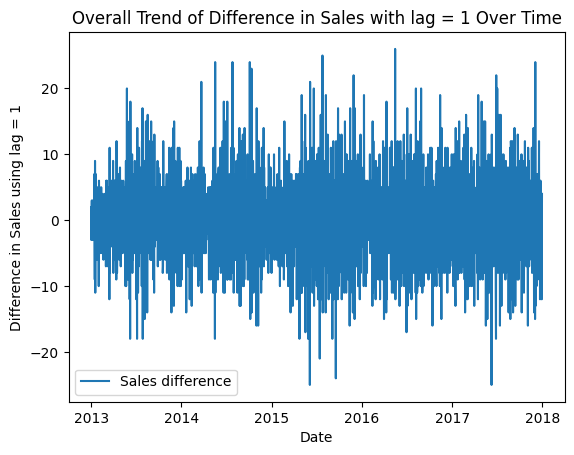

In [8]:
#visualising our new differenced data
sns.lineplot(x="date", y="sales", data=df_copy)
plt.xlabel("Date")
plt.ylabel("Difference in Sales using lag = 1")
plt.title("Overall Trend of Difference in Sales with lag = 1 Over Time")
plt.legend(["Sales difference"])
plt.show()

In [9]:
#checking stationarity of the differenced data
check_stationarity(df_copy['sales'])

ADF Statistic: -12.676793886047415
p-value: 1.2109276320440208e-23
Reject the null hypothesis. The data is stationary.


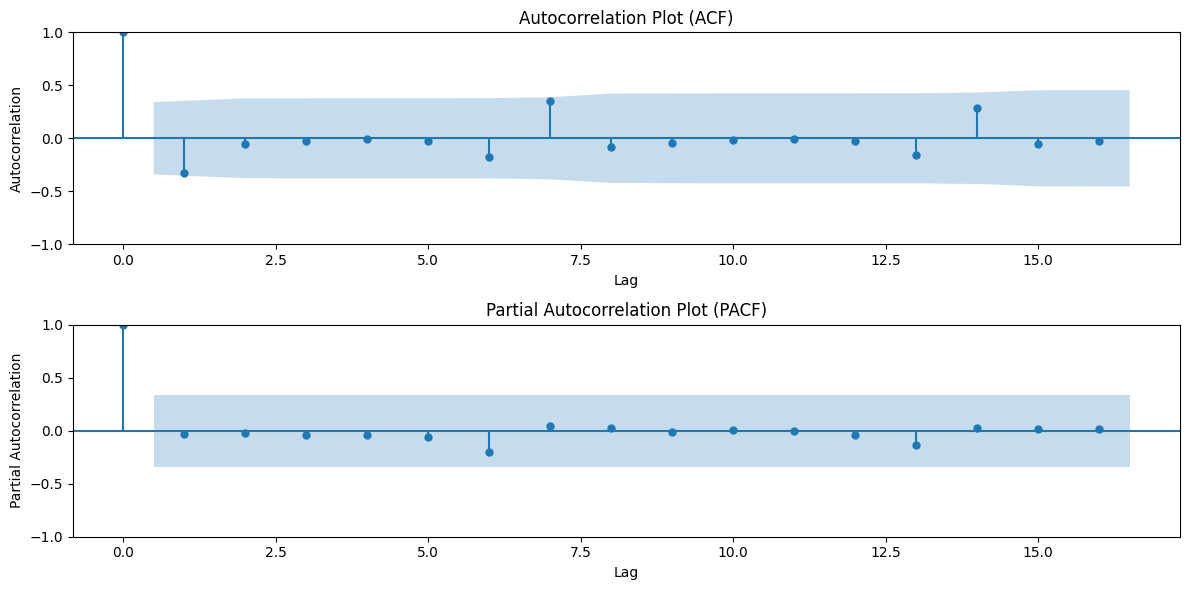

In [10]:
# Calculating autocorrelation and partial autocorrelation
df_acf2 = acf(df_copy['sales'])           # Defining Auto correlation plot
df_pacf2 = pacf(df_copy['sales'])         # Defining Partial auto correlation plot

# Creating subplots for ACF and PACF plots
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plotting ACF
plot_acf(df_acf2, ax=ax1)
ax1.set_title('Autocorrelation Plot (ACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')

# Plotting PACF
plot_pacf(df_pacf2, ax=ax2)
ax2.set_title('Partial Autocorrelation Plot (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

From the above calculated metrics and plots, we see that our data is now stationary. As simple differencing makes our data stationary, we will use d = 1 as a parameter for fitting our ARIMA model. Keep in mind that we were lucky that a simple differencing made the data stationary. Usually a lot of different differencing ideas have to be tried to reach statioanry as it is a very ideal assumotions and there is no guarentee that a time series will be stationary.

## Fitting the ARIMA model

While training a Machine Learning model, we split our 'Supervised' Dataset into a Training Dataset and a Testing Dataset. We use the training dataset to 'train' our model and the testing dataset to verify how accurate our trained model is at predicting on unknown data (The training data is unknown to the model as we have not used it to train the paramaters).

  1. X_train: This will be the training set of features (size = 80% of training set).
  2. X_test: This will be the testing set of features (size = 20% of testing set).
  3. y_train: This will be the corresponding training set of target values (size = 80% of training set).
  4. y_test: This will be the corresponding testing set of target values (size = 20% of testing set).

By default, 80% of the data will be used for training (X_train and y_train), and 20% will be used for testing (X_test and y_test).. It is a standard practise to use an 80-20 split. The motivation behind this is loosely the Pareto principle.The Pareto principle is not a mathematically guaranteed property, but many observed phenomena follow the Pareto principle. As it is seen ubiquitous in nature, we try to emulate the same conjecture with our model. After all, we are trying to emulate 'intelligence'.

In [39]:
#dividing the data into training and testing datasets
df_train_arima = df[:int(0.8*(len(df)))]
df_test_arima = df[int(0.8*(len(df))):]

In [40]:
#defining the ARIMA model with relevant p,d,q parameters
model = statsmodels.tsa.arima.model.ARIMA(df['sales'], order=(1,1,1))
fit_model = model.fit()

In [41]:
#forecasting values on the testing dataset
df_test_arima['forecast'] = fit_model.predict(start = df_test_arima.index[0], end = df_test_arima.index[-1])
df_test_arima

<ipython-input-41-39f836dc4e46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_arima['forecast'] = fit_model.predict(start = df_test_arima.index[0], end = df_test_arima.index[-1])


,date,sales,forecast
1460,2016-12-31,14,17.939589
1461,2017-01-01,19,16.902685
1462,2017-01-02,15,17.431197
1463,2017-01-03,10,16.948956
1464,2017-01-04,16,16.037696
...,...,...,...
1821,2017-12-27,14,16.433387
1822,2017-12-28,19,16.096195
1823,2017-12-29,15,16.688331
1824,2017-12-30,27,16.264695


## Visualising Results

<ipython-input-42-0f7064159a6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_arima['error'] = df_test_arima['sales'] - df_test_arima['forecast']


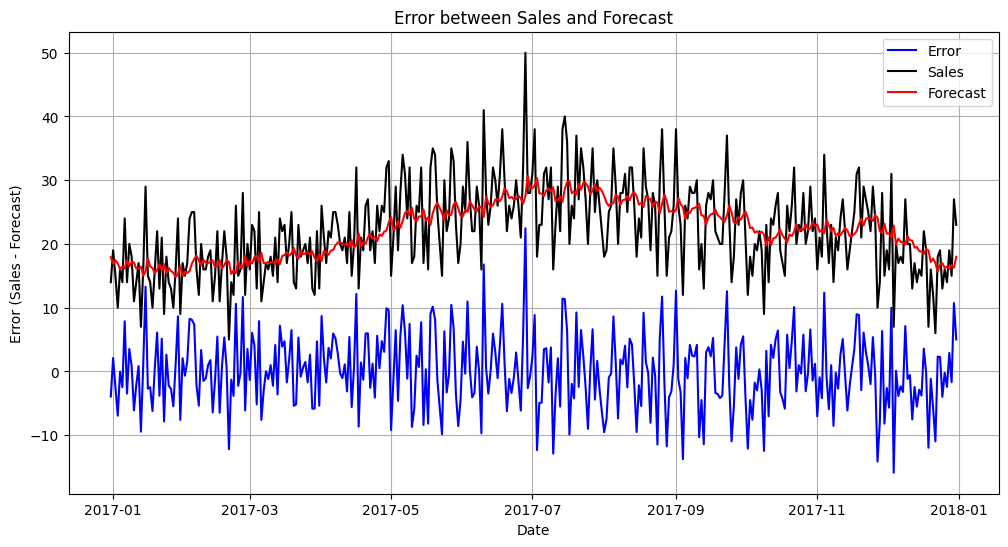

In [42]:
# Step 1: Calculate the error
df_test_arima['error'] = df_test_arima['sales'] - df_test_arima['forecast']

# Step 2: Visualize the error
plt.figure(figsize=(12, 6))
plt.plot(df_test_arima['date'], df_test_arima['error'], color='blue', label="Error")
plt.plot(df_test_arima['date'], df_test_arima['sales'], color='black', label="Sales")
plt.plot(df_test_arima['date'], df_test_arima['forecast'], color='red', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Error (Sales - Forecast)')
plt.title('Error between Sales and Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Step 3: Calculate the mean error (ME) and root mean squared error (MSE)
ME = np.mean(df_test_arima['error'])
RMSE = np.sqrt(np.mean(df_test_arima['error'] ** 2))
RMSE_per_of_avgsales = (RMSE / np.mean(df_test_arima['sales']) )*100

print(f"Mean Error (ME): {ME}")
print(f"Root Mean Squared Error (RMSE): {RMSE}")
print(f"RMSE as a percentage of average sales: {RMSE_per_of_avgsales}%")

Mean Error (ME): 0.007664849330170219
Root Mean Squared Error (RMSE): 5.84990337855445
RMSE as a percentage of average sales: 26.397048903352594%


We see that the mean error is very small but the RMSE as a percentage of sales is high. This indicates that the model captures the trend but does not capture the variance.

Let us plot a graph to visualise the actual price forecast and the predicted price forecast.

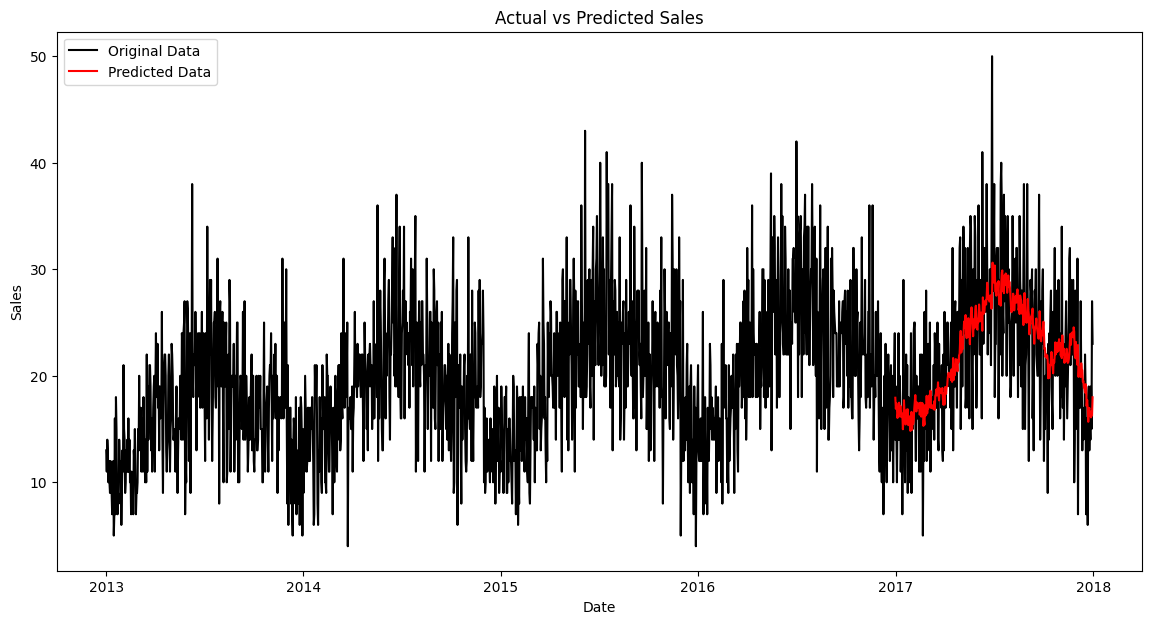

In [44]:
# Plotting actual vs predicted results
plt.figure(figsize=(14,7))
plt.plot(df['date'], df['sales'], color='black', label="Original Data")
plt.plot(df_test_arima['date'], df_test_arima['forecast'], color='red', label="Predicted Data")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

## Conclusion

From our exercise, we can say

1. We see that our ARIMA model has caputured the trend of the underlying data pretty well. It closely follows the mean of the trend.
2. It has not been able to capture the intricacies of the spread apart from a basic trend. This may be due to the inherent underfitting nature of ARIMA.
3. One reason I think that the ARIMA is not a great fit for this data is that the data had some seasonal patterns and more complex relationships apart from the basic regression, which ARIMA is not good at capturing.

ARIMA is not usually very good at capturing long term trends as well. The variance keeps on increasing the further we go into the future and the trend line doesnt perform as well. As we have a very strcutured and possibly manufactured dataset, it is very diffciult to show this as our model will fit the data well into the future.

In general, we can say that ARIMA is alright for a simple series but does not perform well for complex real-world scenarios. Thre are a few pros and cons of the ARIMA model.

**Pros:**

1. Flexibility: ARIMA models can capture a wide range of temporal patterns, including trend, seasonality, and autocorrelation, making them suitable for various types of time series data.
Interpretability: The parameters of ARIMA models (e.g., autoregressive order, moving average order, differencing order) have clear interpretations, making it easier to understand the underlying dynamics of the data.
2. Well-Studied: ARIMA models have been extensively studied and are well-established in the literature. There are robust methodologies for parameter estimation, model diagnostics, and forecasting evaluation.
No Assumptions About Data Distribution: ARIMA models do not assume a specific distribution for the underlying data, making them suitable for non-normal or unknown distributions.
3. Easily Implementable: ARIMA models are relatively easy to implement, especially with the availability of software packages and libraries (e.g., statsmodels in Python).

**Cons:**

1. Stationarity Requirement: ARIMA models assume that the time series data is stationary or can be made stationary through differencing. In practice, achieving stationarity may require complex transformations or detrending techniques.
2. Limited Handling of Seasonality: Traditional ARIMA models do not handle seasonal patterns explicitly. Seasonal ARIMA (SARIMA) models address this limitation by incorporating seasonal components, but they may require more parameters and data for estimation.
3. Sensitivity to Model Selection: Selecting the appropriate orders (p, d, q) for the autoregressive, differencing, and moving average components of the ARIMA model can be challenging and often requires diagnostic checks and model selection criteria.
4. Limited Forecast Horizon: ARIMA models are generally suitable for short to medium-term forecasting. For longer-term forecasts or when dealing with highly volatile or complex data, other forecasting methods like machine learning algorithms may be more appropriate.
5. Assumption of Linear Relationships: ARIMA models assume linear relationships between past observations and future values, which may not always hold true in practice, especially for nonlinear or dynamic systems.

In summary, while ARIMA models offer many advantages, they also have limitations, particularly regarding the stationarity assumption, handling of seasonality, sensitivity to model selection, and forecasting horizon. Understanding these pros and cons is essential for effectively applying ARIMA models to real-world time series data.